In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import seaborn as sns
import datetime as dt
import numpy as np
import scipy as sp
from pymea import plotting
from pymea import matlab_compatibility as mc
from matplotlib import pyplot as plt

Load Data
=========

In [3]:
#data_path = '/media/sam/hdd1/maestro_recordings/016/profile_test.csv'
data_path = '/media/sam/hdd1/maestro_recordings/016/016_minute_binsize.csv'
start_times_path = '/media/sam/hdd1/maestro_recordings/016/016_start_times.csv'
data_table = pd.read_csv(data_path)

In [4]:
start_times = pd.read_csv(start_times_path)
start_times = start_times['Var1'].map(mc.datetime_str_to_datetime)
time_vector = data_table['time'].map(mc.datetime_str_to_datetime)

Filter Useless Time Points
==========================

In [5]:
mins = dt.timedelta(minutes=29)
before_min = dt.timedelta(minutes=5)
good_recording_times = time_vector < start_times[2]
for st in start_times[2:]:
    good_recording_times[(time_vector > (st + before_min)) & (time_vector < (st + mins))] = True

In [6]:
print data_table.shape
data_table = data_table[good_recording_times]
print data_table.shape

(7092, 302)
(5394, 302)


In [7]:
def is_even(num):
    return num % 2 == 0

def ttx_filter(name):
    row_num, col_num = mc.get_row_col_number_tuple(name)
    return (is_even(row_num) and is_even(col_num)) or not (is_even(row_num) or is_even(col_num))
    
def no_ttx_filter(name):
    row_num, col_num = mc.get_row_col_number_tuple(name)
    return(is_even(row_num) and not is_even(col_num)) or (not is_even(row_num) and is_even(col_num))

In [8]:
def smooth_columns(table, smooth_size):
    kernel = np.ones(smooth_size)/smooth_size
    for column in table.columns:
        table[column] = np.convolve(table[column], kernel, 'same')
        
    return table

In [9]:
time_vector = data_table['time'].map(mc.datetime_str_to_datetime)
unit_table = data_table.drop('time', axis=1)
unit_table = unit_table/60 # convert to hertz
unit_table = unit_table.drop('D3241', axis=1) # abnormal nottx unit
unit_table = unit_table.drop('B2111', axis=1) # abnormal ttx unit

In [10]:
ttx_cols = filter(ttx_filter, unit_table.columns)
no_ttx_cols = filter(no_ttx_filter, unit_table.columns)

In [11]:
empty_time_bins = unit_table.sum(axis=1) == 0

In [12]:
unit_table = unit_table.loc[~empty_time_bins, :].reset_index()
unit_table = unit_table.drop('index', axis=1)
times = time_vector[~empty_time_bins]

In [13]:
unit_table = smooth_columns(unit_table, 45)

Plot All Electrodes
===================

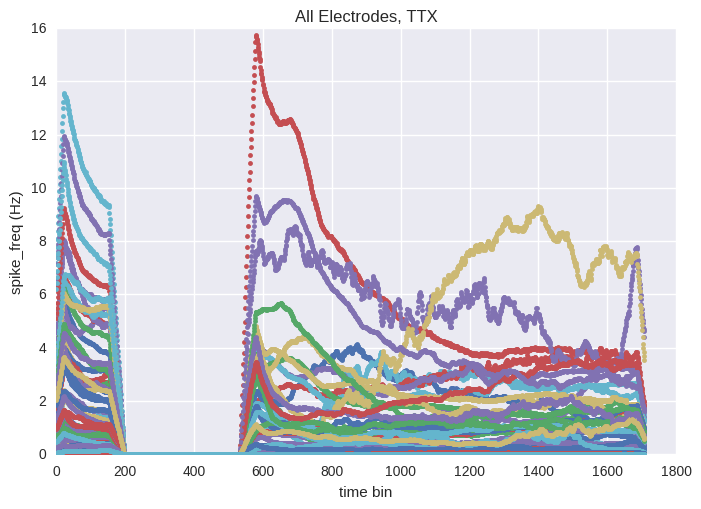

In [14]:
plt.figure()
for c in ttx_cols:
    plt.plot(unit_table[c], '.')
    
plt.title('All Electrodes, TTX')
plt.ylabel('spike_freq (Hz)')
plt.xlabel('time bin')
plt.savefig('ttx_allelectrodes_individual_freq_traces.png')

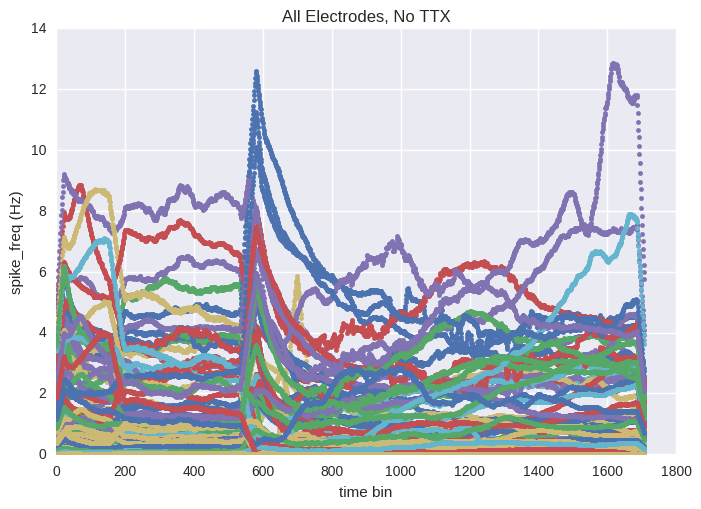

In [15]:
plt.figure()
for c in no_ttx_cols:
    plt.plot(unit_table[c], '.')
    
plt.title('All Electrodes, No TTX')
plt.ylabel('spike_freq (Hz)')
plt.xlabel('time bin')
plt.savefig('nottx_allelectrodes_individual_freq_traces.png')

Plot Fast Spiking Electrodes
============================

In [16]:
#fast_spiking_units = unit_table.loc[-100:, :].mean(axis=0) > 1
#fast_spiking_unit_table = unit_table.loc[:, fast_spiking_units]
#fs_ttx_cols = filter(ttx_filter, fast_spiking_unit_table.columns)
#fs_no_ttx_cols = filter(no_ttx_filter, fast_spiking_unit_table.columns)

In [36]:
offset = 1000
sample_size = 14
ttx_mean_spike_rates = unit_table[ttx_cols][1000:1200].mean(axis=0).sort_values()
fs_ttx_cols = ttx_mean_spike_rates.index[-sample_size:]

no_ttx_mean_spike_rates = unit_table[1000:1200][no_ttx_cols].mean(axis=0).sort_values()
no_ttx_mean_spike_rates.sort_values()
fs_no_ttx_cols = no_ttx_mean_spike_rates.index[-sample_size:]

fast_spiking_unit_table = unit_table[fs_ttx_cols | fs_no_ttx_cols]

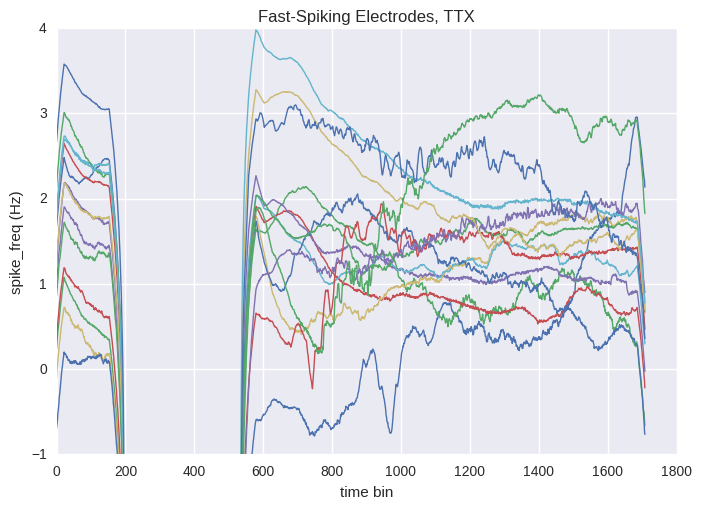

In [37]:
for c in fs_ttx_cols:
    plt.plot(fast_spiking_unit_table[c].map(np.log2), lw=1)
    
plt.title('Fast-Spiking Electrodes, TTX')
plt.ylabel('spike_freq (Hz)')
plt.xlabel('time bin')
plt.ylim((-1,4))
plt.savefig('ttx_fastspiking_individual_freq_traces.png')

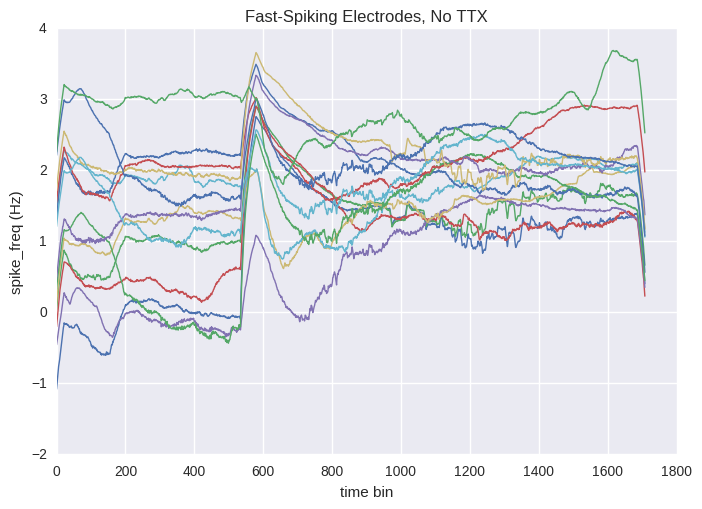

In [38]:
plt.figure()
for c in fs_no_ttx_cols:
    plt.plot(fast_spiking_unit_table[c].map(np.log2), lw=1)
    
plt.title('Fast-Spiking Electrodes, No TTX')
plt.ylabel('spike_freq (Hz)')
plt.xlabel('time bin')
plt.savefig('nottx_fastspiking_individual_freq_traces.png')

In [39]:
mean_fs_ttx = fast_spiking_unit_table[fs_ttx_cols].mean(axis=1)
mean_fs_no_ttx = fast_spiking_unit_table[fs_no_ttx_cols].mean(axis=1)

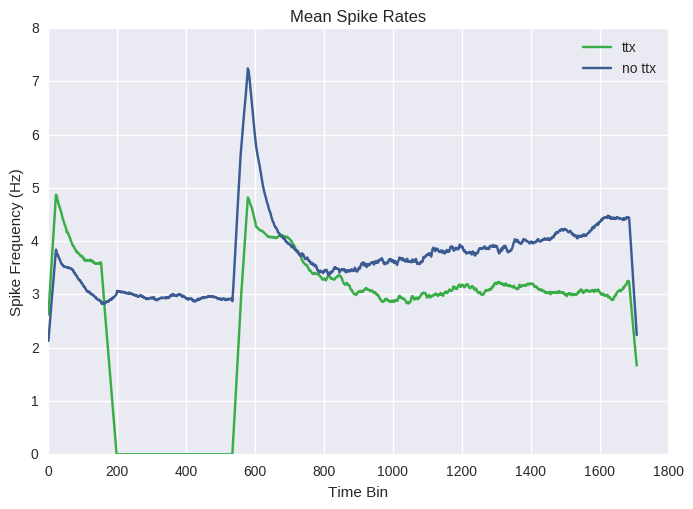

In [40]:
plt.figure()
plt.plot(mean_fs_ttx, color=sns.xkcd_rgb['medium green'], label='ttx')
plt.plot(mean_fs_no_ttx, color=sns.xkcd_rgb['denim blue'], label='no ttx')
plt.legend(['ttx', 'no ttx'])
plt.ylabel('Spike Frequency (Hz)')
plt.xlabel('Time Bin')
plt.title('Mean Spike Rates')
plt.savefig('fast_spiking_units_mean_freq_20min_smooth.png')

In [41]:
geo_mean_fs_ttx = sp.stats.mstats.gmean(fast_spiking_unit_table[fs_ttx_cols], axis=1)
geo_mean_fs_no_ttx = sp.stats.mstats.gmean(fast_spiking_unit_table[fs_no_ttx_cols], axis=1)

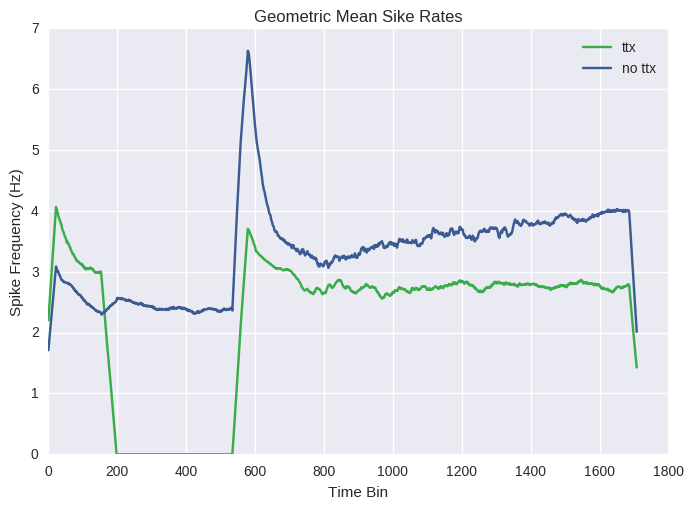

In [42]:
plt.figure()
plt.plot(geo_mean_fs_ttx, color=sns.xkcd_rgb['medium green'], label='ttx')
plt.plot(geo_mean_fs_no_ttx, color=sns.xkcd_rgb['denim blue'], label='no ttx')
plt.legend(['ttx', 'no ttx'])
plt.ylabel('Spike Frequency (Hz)')
plt.xlabel('Time Bin')
plt.title('Geometric Mean Sike Rates')
plt.savefig('fast_spiking_units_geomean_freq_20min_smooth.png')

In [43]:
mean_ttx = unit_table[ttx_cols].mean(axis=1)
mean_no_ttx = unit_table[no_ttx_cols].mean(axis=1)

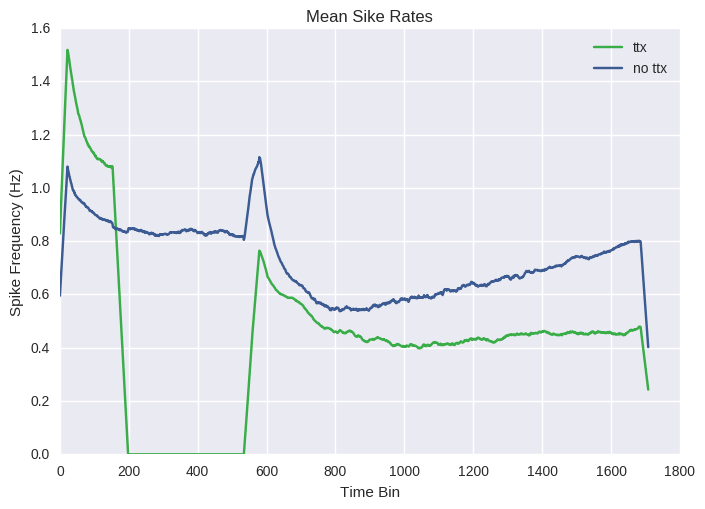

In [44]:
plt.figure()
plt.plot(mean_ttx, color=sns.xkcd_rgb['medium green'], label='ttx')
plt.plot(mean_no_ttx, color=sns.xkcd_rgb['denim blue'], label='no ttx')
plt.legend(['ttx', 'no ttx'])
plt.ylabel('Spike Frequency (Hz)')
plt.xlabel('Time Bin')
plt.title('Mean Sike Rates')
plt.savefig('all_units_mean_freq.png')

In [26]:
fast_spiking_mean = fast_spiking_unit_table.mean(axis=1)

In [27]:
fast_spiking_norm = fast_spiking_unit_table.divide(fast_spiking_mean, axis='index')

In [28]:
norm_fs_ttx = fast_spiking_norm[fs_ttx_cols].mean(axis=1)
norm_fs_no_ttx = fast_spiking_norm[fs_no_ttx_cols].mean(axis=1)

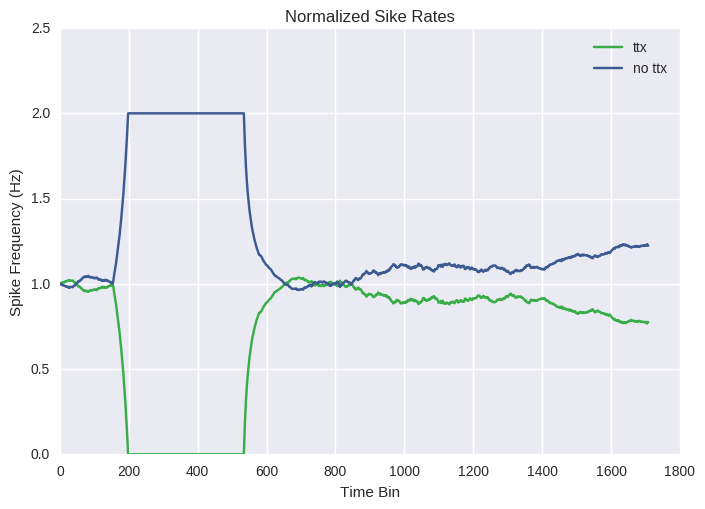

In [45]:
plt.figure()
plt.plot(norm_fs_ttx, color=sns.xkcd_rgb['medium green'], label='ttx')
plt.plot(norm_fs_no_ttx, color=sns.xkcd_rgb['denim blue'], label='no ttx')
plt.legend(['ttx', 'no ttx'])
plt.ylabel('Spike Frequency (Hz)')
plt.xlabel('Time Bin')
plt.title('Normalized Sike Rates')
plt.savefig('fast_spiking_units_normalized_freq.png')

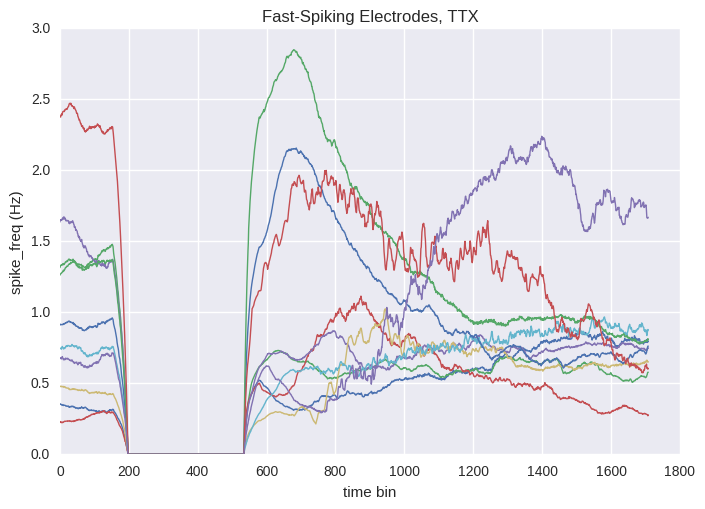

In [34]:
plt.figure()
for c in fs_ttx_cols:
    plt.plot(fast_spiking_unit_table[c].divide(fast_spiking_mean, axis='index'), lw=1)
    
plt.title('Fast-Spiking Electrodes, TTX')
plt.ylabel('spike_freq (Hz)')
plt.xlabel('time bin')
plt.savefig('ttx_fastspiking_individual_freq_traces_norm.png')

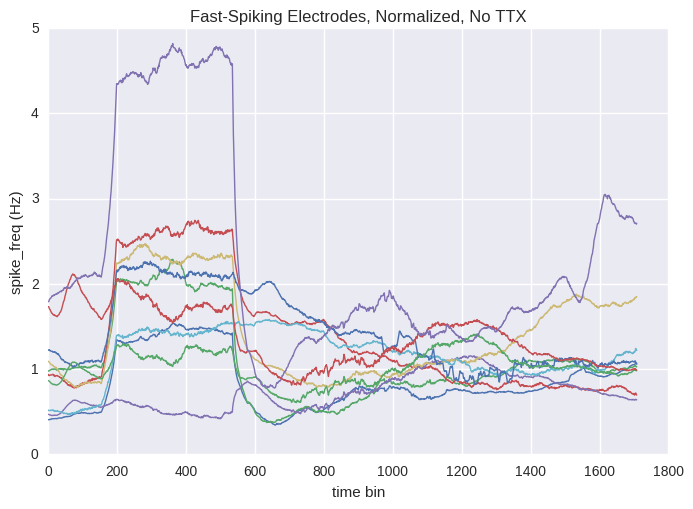

In [35]:
plt.figure()

for c in fs_no_ttx_cols:
    plt.plot(fast_spiking_unit_table[c].divide(fast_spiking_mean, axis='index'), lw=1)
    
plt.title('Fast-Spiking Electrodes, Normalized, No TTX')
plt.ylabel('spike_freq (Hz)')
plt.xlabel('time bin')
plt.savefig('nottx_fastspiking_individual_freq_traces_norm.png')

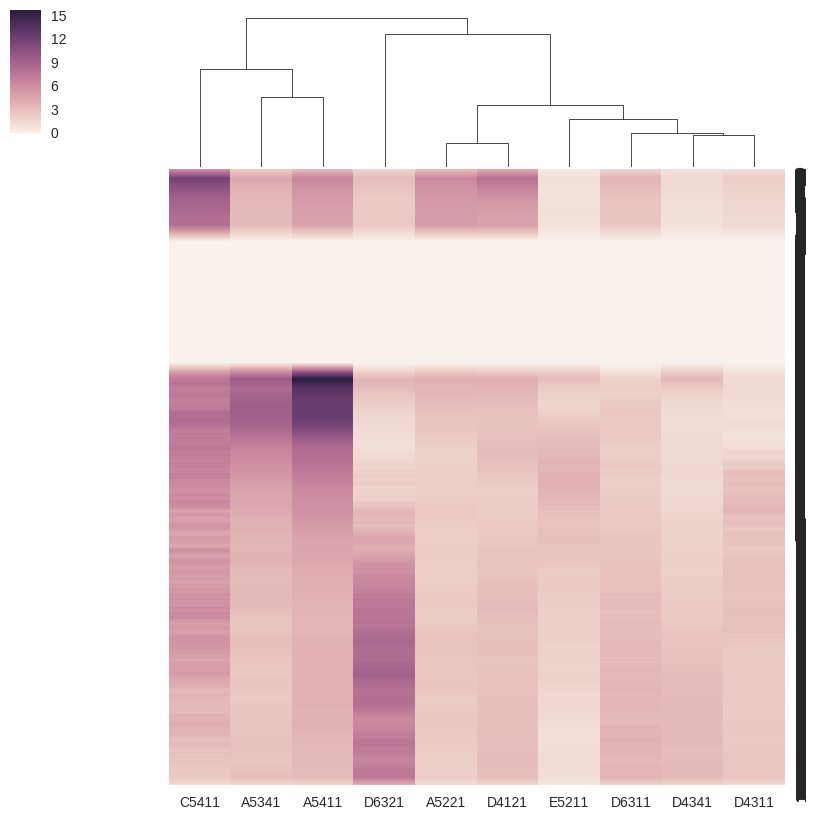

In [32]:
sns.clustermap(fast_spiking_unit_table[fs_ttx_cols], row_cluster=False)

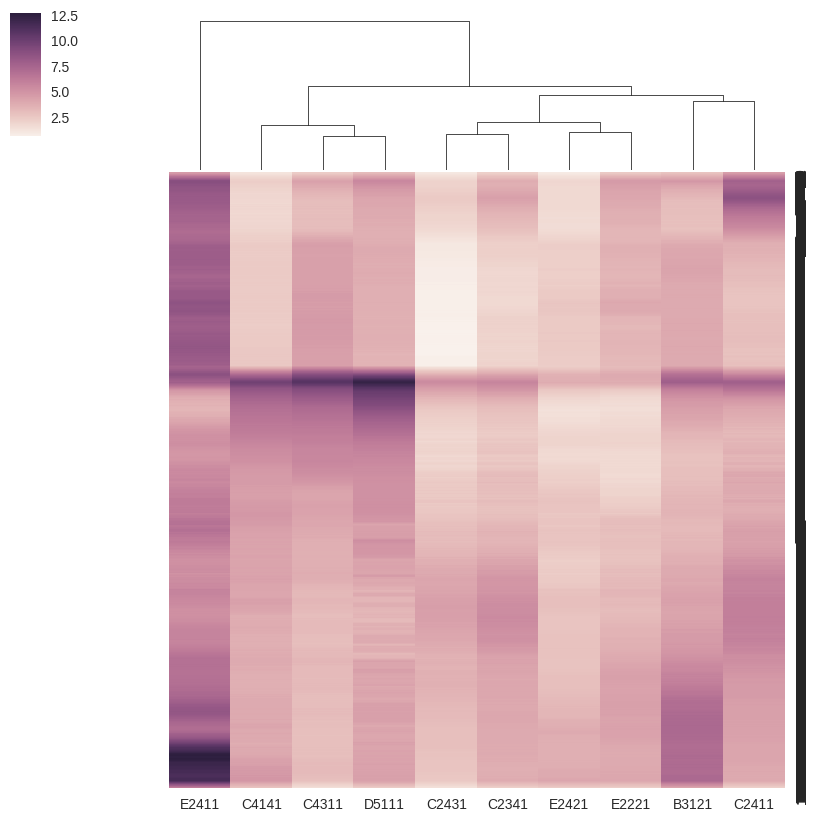

In [33]:
sns.clustermap(fast_spiking_unit_table[fs_no_ttx_cols], row_cluster=False)